# Building Autoencoders in ~~Keras~~ PyTorch

WNixalo – 2018/6/16

[Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

In [3]:
import matplotlib.pyplot as plt

In [4]:
import copy

## 1. Building the simplest possible autoencoder

> We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

```
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32 # 32 floats -> compression of factor 24.5 assuming input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
```

> Let's also create a separate encoder model:

```
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
```
> As well as the decoder model:

```
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
```

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
input_size   = 784
encoding_dim = 32

In [7]:
# writing full classes for the en/de-coders is overkill, but this is the 
# general form of writing pytorch modules.

class Encoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, encoding_dim), nn.ReLU()])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
            
class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(encoding_dim, input_size)])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, input_size=784, encoding_dim=32):
        super().__init__()
        self.encoder = Encoder(input_size, encoding_dim)
        self.decoder = Decoder(encoding_dim, input_size)
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten to (nm,1) vector
        x = self.encoder(x)  # Encode
        x = self.decoder(x)  # Decode
        x = F.sigmoid(x)
        x = x.reshape(x.size(0),1,28,28) # should be a more elegant way to do this
        return x

In [8]:
autoencoder = Autoencoder(784, 32)

> Now let's train our autoencoder to reconstruct MNIST digits.
>
> First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

```
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
```

> Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

```
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
```

> We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

```
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test  = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)
```

In [10]:
# # these are actually initialized within the training loop
# optimizer = torch.optim.Adadelta(autoencoder.parameters())
# criterion = torch.nn.BCELoss()

In [9]:
import torchvision

In [10]:
bs = 16

# stats = [[0.1307],[0.3073]] # calculated from training set

tfm0 = torchvision.transforms.ToTensor()  # convert [0,255] -> [0.0,1.0]
# tfm1 = torchvision.transforms.Normalize(*stats) # normalize to [-1.0,+1.0]

# tfms = [tfm0, tfm1]
# tfms = torchvision.transforms.Compose(tfms)

In [11]:
train_dataset = torchvision.datasets.MNIST('data/MNIST/',train=True, transform=tfm0)
test_dataset  = torchvision.datasets.MNIST('data/MNIST/',train=False,transform=tfm0)

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_dataset,  batch_size=bs)

---

### Aside: Flattening Tensors and Untrained Autoencoder output

multiple ways to flatten tensors:

In [12]:
# get minibatch
x,_ = next(iter(train_loader)); x_test,_ = next(iter(test_loader))
# check ea. way to flatten is identical
compare0 = torch.equal(np.reshape(x, (len(x), np.prod(x.shape[1:]))),
                       x.reshape(len(x), np.prod(x.shape[1:])))
compare1 = torch.equal(x.view(x.size(0), -1), x.reshape(len(x), np.prod(x.shape[1:])))
print(True == compare0 == compare1)
# display flattened minibatch shapes
print(x.view(x.size(0), -1).shape)
print(x_test.view(x_test.size(0), -1).shape)

True
torch.Size([16, 784])
torch.Size([16, 784])


Here's a test of the autoencoder without any training (you'd expect just noise):

In [13]:
x,y = next(iter(train_loader))
z = autoencoder(x)

In [14]:
z.shape

torch.Size([16, 1, 28, 28])

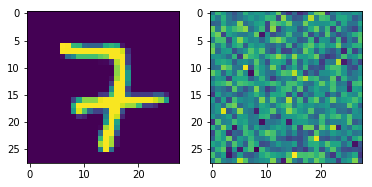

In [197]:
fig,axes = plt.subplots(1,2); plt.set_cmap(['gray','viridis'][1]);
axes[0].imshow(x[0][0].numpy()); axes[1].imshow(z[0][0].detach().numpy());

In [15]:
def compare_plot(x,z, idx=0, cdx=1):
    """assumes x,y (bs,1,28,28) tensors"""
    fig,axes = plt.subplots(1,2); plt.set_cmap(['gray','viridis'][cdx]);
    if type(z) == torch.Tensor: z = z.detach().numpy()
    axes[0].imshow(x[idx][0].numpy()); axes[1].imshow(z[idx][0]);

---

> Now let's train our autoencoder for 50 epochs:

```
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True,
                validation_data=(x_test, x_test))
```

> After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about `0.11`. We can try to visualize the reconstrubted inputs and the encoded representations. We will use Matplotlib.

```
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
```

```
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
```

In [16]:
def train(model, trainloader=None, valloader=None, num_epochs=1):
    # use GPU0 if available # pytorch >= 0.4
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # name dataloaders for phases
    phases = ['train']
    dataloaders = {'train':trainloader}
    if valloader:
        phases.append('valid')
        dataloaders['valid'] = valloader
    
    # move model to gpu -- pytorch >= 0.4 ## NOTE: havent tested on gpu yet
    model.to(device)
    optimizer = torch.optim.Adadelta(autoencoder.parameters())
    criterion = torch.nn.BCELoss()
    
    # epoch w/ train & val phases
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}\n{"-"*10}')
        
        for phase in phases:
            if phase == 'train':
                #scheduler.step() # (no LR scheduler this time)
                model.train() # set model to training mode
            else: model.eval() # set model to evaluation mode
                
            running_loss, running_correct, count = 0.0, 0, 0
        
            for i, minibatch in enumerate(dataloaders[phase]):
                x,y = minibatch
                x,y = x.to(device), y.to(device)

                # zero param gradients
                optimizer.zero_grad()

                # forward: track history if training phase
                with torch.set_grad_enabled(phase=='train'): # pytorch >= 0.4
                    outputs = model(x)
                    loss    = criterion(outputs, x)
                    preds,_ = torch.max(outputs,1) # for accuracy metric
                    # backward & optimize if training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # stats
                running_loss += loss.item() * x.size(0)
                count += len(x)
            
            epoch_loss = running_loss / count
            print(f'{phase} loss {epoch_loss:.6f}')
        print()

In [205]:
%time train(autoencoder, trainloader=train_loader, valloader=test_loader, num_epochs=1)

Epoch 1/1
----------
CPU times: user 54.4 s, sys: 1.3 s, total: 55.7 s
Wall time: 19.7 s


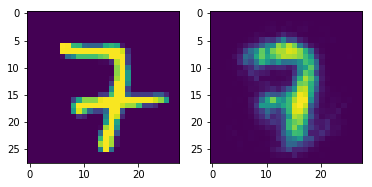

In [211]:
x,y = next(iter(train_loader))
z = autoencoder(x)
compare_plot(x,z)

Woah.

---

### Aside: Fast.AI

FChollet makes use of TensorBoard to make some fancy plots of the training process. Also, Keras isn't at PyTorch's abstraction level: PyTorch is comparable to TensorFlow, Keras' backend. So instead of doing all my training manually, I'm going to modify the pytorch dataloaders a bit so I can use them with fastai for training. This'll give me some powerful high-level control over the process.

In [17]:
# create copies of dataloaders for ModelData
train_loadermd = copy.deepcopy(train_loader)
test_loadermd  = copy.deepcopy(test_loader)

# set y to be x and convert [0,255] int to [0.0,1.0] float. (dl doesnt trsfm `y` by default)
train_loadermd.dataset.train_labels = train_loadermd.dataset.train_data.type(torch.FloatTensor)/255
test_loadermd.dataset.test_labels   = test_loadermd.dataset.test_data.type(torch.FloatTensor)/255

# add channel dimension for compatibility. (bs,h,w) –> (bs,ch,h,w)
train_loadermd.dataset.train_labels = train_loadermd.dataset.train_labels.reshape((len(train_loadermd.dataset),1,28,28))
test_loadermd.dataset.test_labels   = test_loadermd.dataset.test_labels.reshape((len(test_loadermd.dataset),1,28,28))

In [18]:
from fastai.conv_learner import *

In [19]:
md = ModelData('data/MNIST', train_loadermd, test_loadermd)

In [20]:
learn = Learner.from_model_data(Autoencoder(), md)
learn.crit = F.binary_cross_entropy

epoch      trn_loss   val_loss                                  
    0      0.142973   0.154716  


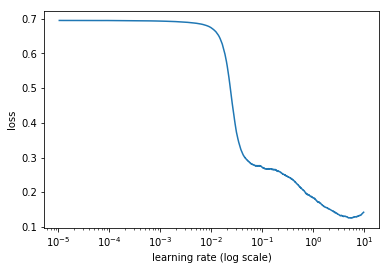

In [174]:
learn.lr_find()
learn.sched.plot()

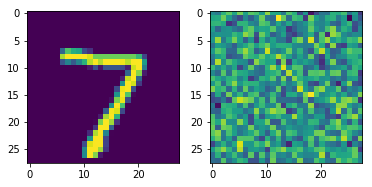

In [175]:
z = learn.predict()        # run learner on val data
x = md.val_ds.test_data[0] # get X from val dataset
compare_plot([[x]], z) # expects dims: (batchsize, channels, rows, cols)

epoch      trn_loss   val_loss                                  
    0      0.264682   0.262922  


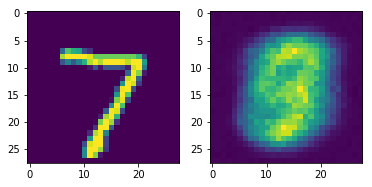

In [176]:
learn.fit(0.01, 1)     # fit learner to data
z = learn.predict()    # run learner on val data
compare_plot([[x]], z) # display X vs Z

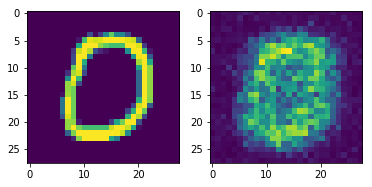

In [188]:
x = md.val_ds.test_data.reshape(len(md.val_ds),1,28,28)
compare_plot(x, z, idx=10)

---

Now that I got fastai working with the data, I can easily train 50 epochs. Although, to show how quickly the model converges w/ MNIST data, here's the result of a couple epochs via pure-pytorch:

In [221]:
autoencoder = Autoencoder()
train(autoencoder, train_loader, test_loader, num_epochs=2)

Epoch 1/2
----------
train loss 0.200236
valid loss 0.148270

Epoch 2/2
----------
train loss 0.131812
valid loss 0.117702



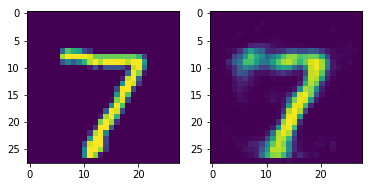

In [223]:
x,y = next(iter(test_loader))
z = autoencoder(x)
compare_plot(x, z)

Now to train for 50 epochs with fastai:

In [242]:
autoencoder = Autoencoder()
learner = Learner.from_model_data(autoencoder, md)
learner.crit = F.binary_cross_entropy
learner.opt_fn = torch.optim.Adadelta

epoch      trn_loss   val_loss                                 
    0      0.180425   0.171059  


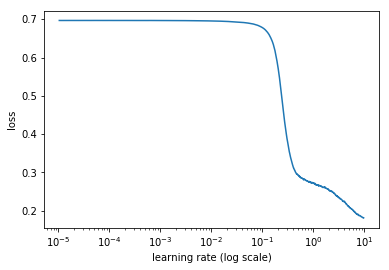

In [243]:
learner.lr_find()
learner.sched.plot()

Looks like I'll have to use a really aggressive learning rate just to get started anywhere. The `torch.optim.Adadelta` optimizer's default was `1.0` in the pytorch training loop. I'm training for 50 epochs anyway (to match the tutorial) so I'll go with `0.5`. The tutorial is also using batch sizes of 256, but I'm using 16 (for no particular reason than not wanting to reinitialize everything).

Nothing special with training: just 50 cycles, each 1 epoch long, using default [Cosine Annealing](https://arxiv.org/abs/1608.03983), no weight decay. 

In [245]:
learner.fit(0.5, n_cycle=50)

epoch      trn_loss   val_loss                                 
    0      0.180503   0.179986  
    1      0.146636   0.145664                                 
    2      0.127929   0.126243                                 
    3      0.116537   0.114927                                 
    4      0.110755   0.108692                                 
    5      0.106966   0.105151                                 
    6      0.104011   0.102819                                 
    7      0.102981   0.101205                                 
    8      0.100336   0.099909                                  
    9      0.101887   0.099023                                   
    10     0.10073    0.098413                                   
    11     0.098454   0.097746                                   
    12     0.099941   0.097324                                   
    13     0.096887   0.096923                                   
    14     0.097922   0.096655                              

[0.09377471673488617]

In [246]:
learn.save('pytorch-autoencoder-50ep')

In [263]:
x,y = next(iter(md.val_dl)) # get 1st minibatch
z = learner.predict()

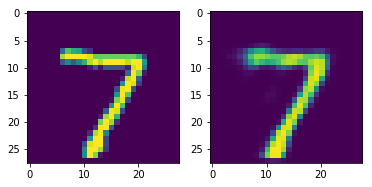

In [266]:
compare_plot(x,z)

In [22]:
def compare_batch(x, z, bs=16, figsize=(16,2)):
    bs = min(len(x), bs) # digits to display
    fig = plt.figure(figsize=figsize)
    for i in range(bs):
        # display original
        ax = plt.subplot(2, bs, i+1); ax.imshow(x[i].reshape(28,28))
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        ax = plt.subplot(2, bs, i+1+bs); ax.imshow(z[i].reshape(28,28))
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)

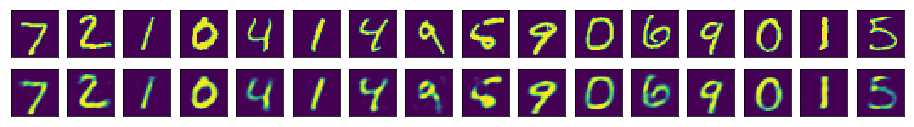

In [286]:
compare_batch(x,z)

> Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

<img src="https://blog.keras.io/img/ae/basic_ae_32.png">

## 2. Adding a sparsity constraint on the encoded representations

> In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically ahppens is that the hidden layer is learning an approximation of [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) [(principal component analysis)](https://en.wikipedia.org/wiki/Principal_component_analysis). But another way to constrain the representations to be compact is to add a sparsity constraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an `activity_regularizer` to our `Dense` layer:

```
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)
```

> Let's train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer). The model ends with a train loss of `0.11` and a test loss of `0.10`. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01).

Fast AI's Learner has a built-in regularization function attribute. 

Internally in `fastai.model.Stepper` in the `step(.)` function, the `output` is calculated by passing the input/s into the model `self.m(.)`. If the `output` is a tuple, in the case of multi-headed models or models that also output intermediate activations, `output` is reassigned and destructured: `output` is reassigned to it's 1st item, and `xtra` is a list of all the rest.

`raw_loss` is first calculated on the `output` and `y` using the loss function `self.crit`. If no regularization function is attached to the Learner, the `raw_loss` is returned as the loss. Otherwise, `output`, `xtra`, and `raw_loss` are all passed into the regularizer `self.reg_fn` and the result is returned as loss.

So adding L1 (or any) regularization to a Fast AI Learner is as easy as defining a regularization function that accepts arguments: `output, xtra, raw_loss` and assigning it to `learner.reg_fn`. Also make sure the encoder sends a copy of it

This raises a further question of how exactly was multi-head / output work done, for example in [pascal.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal-multi.ipynb) (multi-head multi-output) and [lesson2-image_models.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson2-image_models.ipynb) (multi-output). In lesson2-image_models that abstraction layer is still hidden, but in pascal.ipynb the SSD model's `OutConv` nn.Module class outputs a *`list`* of [classifications, regressions], so I think that's the big clue. I tested this and the output indeed didn't get destructured.

In [23]:
# writing full classes for the en/de-coders is overkill, but this is the 
# general form of writing pytorch modules.

class EncoderL1(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, encoding_dim), nn.ReLU()])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
            
class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(encoding_dim, input_size)])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class AutoencoderL1(nn.Module):
    """Basic autoencoder with extra encoder output for L1 regularization."""
    def __init__(self, input_size=784, encoding_dim=32):
        super().__init__()
        self.encoder = EncoderL1(input_size, encoding_dim)
        self.decoder = Decoder(encoding_dim, input_size)
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten to (nm,1) vector
        l1x = self.encoder(x)  # Encode
        x = self.decoder(l1x)  # Decode
        x = F.sigmoid(x)
        x = x.reshape(x.size(0),1,28,28) # should be a more elegant way to do this
        return x, l1x # autoencoder and encoder outputs
    
def l1_reg(output, xtra, raw_loss, λ1=1e-4):
    """Adds L1 Regularization to the Loss."""
    return λ1*torch.abs(*xtra).sum() + raw_loss # xtra comes in as list, deconstruct to tensor

In [28]:
learn = Learner.from_model_data(AutoencoderL1(), md)

In [29]:
learn.crit = F.binary_cross_entropy
learn.opt_fn = torch.optim.Adadelta
learn.reg_fn = l1_reg

epoch      trn_loss   val_loss                                 
    0      0.246507   0.239414  


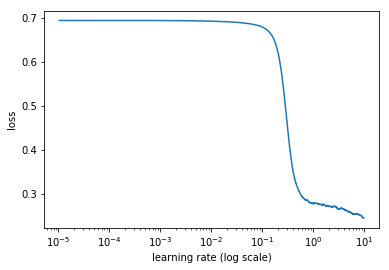

In [30]:
learn.lr_find()
learn.sched.plot()

In [31]:
%time learn.fit(0.5, 100) # same lr as before; now 100 cycles (1 ep/cyc)

epoch      trn_loss   val_loss                                 
    0      0.250728   0.248423  
    1      0.231891   0.231998                                 
    2      0.224072   0.220726                                 
    3      0.218669   0.21725                                  
    4      0.217783   0.21568                                  
    5      0.214344   0.214774                                 
    6      0.214792   0.213973                                 
    7      0.214472   0.21356                                  
    8      0.215391   0.213021                                 
    9      0.214764   0.212651                                 
    10     0.213261   0.212288                                 
    11     0.215662   0.212235                                 
    12     0.215801   0.211687                                 
    13     0.213287   0.211712                                 
    14     0.212363   0.211242                                 
    15 

[0.190795294547081]

I think my learning rate was too low with the added regularization. And I just realized since this is pytorch I could have the model output the encoder outputs for regularization *only* when in training mode. *hmm*, next time.

In [36]:
learn.save('autoencoder_l1reg_100ep')

In [69]:
x = next(iter(learn.data.val_dl))[0]
z = learn.predict()

In [72]:
z.shape, x.shape

((10000, 1, 28, 28), torch.Size([16, 1, 28, 28]))

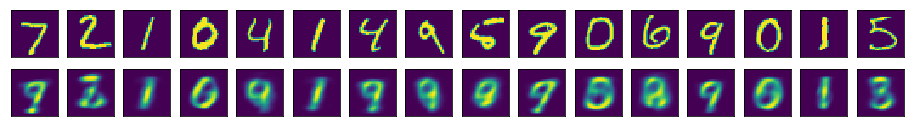

In [71]:
compare_batch(x, z)

> Here's a visualization of our new results:

<img src="https://blog.keras.io/img/ae/sparse_ae_32.png" >

> They look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. `encoded_imgs.mean()` yields a value `3.33` (over our 10,000 test images), whereas with the previous model the same quantity was `7.30`. So our new model yields encoded representations that are twice sparser.

In [104]:
encodings = [] # now its convenient Im getting the encoder's output
for x,_ in iter(learn.data.val_dl):
    encodings.append(learn.model(x)[1].detach().numpy().mean())
np.array(encodings).mean()

0.18292214

## 3. Deep autoencoder

> We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers such as:

```
input_img = Input(shape(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64,  activation='relu')(encoded)
encoded = Dense(32,  activation='relu')(encoded)

decoded = Dense(64,  actication='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
```

> Let's try this:

```
autoencoder = Model(inpu_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True, 
                validation_data=(x_test, x_test))
```

## 4. Convolutional autoencoder

## 5. Application to image denoising

## 6. Sequence–to–sequence autoencoder

## 7. Variational autoencoder (VAE)

---

### Aside: calculating μ & σ of MNIST

I wanted some values to normalize the dataset with. I did this by only passing in the `ToTensor()` transfor to the dataset object and turning off shuffling (though that shouldn't matter), then computing the standard deviation & mean.

On second look, FChollet only normalizes to between `[0.0,1.0]`, so this was unnecessary.

In [99]:
%%time
std,mean,count = 0.,0.,0
for x,_ in train_loader:
    std   += torch.std(x)
    mean  += torch.mean(x)
    count += 1
std  /= count
mean /= count

CPU times: user 4.82 s, sys: 17.3 ms, total: 4.84 s
Wall time: 4.86 s


In [100]:
std, mean

(tensor(0.3073), tensor(0.1307))

---

## dev dump

---

So.. what is an "activity_regularizer"? It forces fewer activations to fire... sounds a lot like Dropout.. Ah but he's using L1.. so he's just adding a penalty on activation, not outright killing them. So how to do that in pytorch. First of all looking at [how Keras does it](https://github.com/keras-team/keras/blob/master/keras/regularizers.py#L53):

```
L1 activity regularizer: regularizers.l1
    ––> regularizers.l1:
        ––> def l1(l=0.01):
                return L1L2(l1=l1)
    ––> class L1L2(Regularizer):
            ...
            def __call__(self, x):
                regularization = 0.
                if self.l1:
                    regularization += K.sum(self.l1 * K.abs(x))
                ...
                return regularization
```

Checking the [Keras source code](https://github.com/keras-team/keras/blob/master/keras/layers/core.py#L816) for what the practical difference between activation vs weight regularization is on a `Dense` layer:

```
    ...
    activity_regularizer: Regularizer function applied to 
        the output of the layer (its "activation").
        (see [regularizer](../regularizers.md)).
    ...
```

Ah, so it's just L1 (`sum(l1 * abs(x))`) on the output. How does that talk to the optimizer though? It has to affect the loss value somehow.

Oh, duh. You [just edit the loss function](https://stackoverflow.com/a/47196174) to now take this L1 loss term. Just checking [fast.ai for how that's implemented](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal-multi.ipynb) again
 (we did exactly this for multi-object detection –– see the "Train" section).
 

Looks like in PyTorch we create a function and assign it to the Fast AI Learner's `.crit` (see `ssd_loss` defn). Also looks like you can create an `nn.Module` class that acts on an input like any other NN. I really like pytorch's flexibility.

Although if I define it as a class, I could directly assign the `l1` multiplier to use via `learn.crit.l1 = ..`. If that becomes a problem I'll 'upgrade' it.

**Edit**: No, no. I got mistaken and started looking at implementing L1 *Loss*. I wanted L1 *Regularization*, which is just a penalty tacked onto the loss value. Luckily adding a regularizer is easy [in pytorch](https://stackoverflow.com/questions/44641976/in-pytorch-how-to-add-l1-regularizer-to-activations) and fastai.

In [292]:
def bce_l1_loss(pred, targ, l1=1e-4):
    return F.binary_cross_entropy(pred, targ) + l1*F.l1_loss(pred, targ)

In [288]:
learn.crit

<function torch.nn.functional.binary_cross_entropy(input, target, weight=None, size_average=True, reduce=True)>

In [293]:
learn.crit = bce_l1_loss

In [294]:
learn.crit

<function __main__.bce_l1_loss(pred, targ, l1=0.0001)>

*Ohh*. I just noticed: the L1 Loss FChollet is using is *on the Encoder*. So I can't just put it on the end of my Autoencoder. This isn't hard. I just have to change the model's architecture to output an L1 loss from the encoder in addition to what was going on before:

---

In [211]:
autoencoder = Autoencoder()

In [212]:
%time train(autoencoder, trainloader=train_loader, valloader=test_loader)

Epoch 1/1
----------
train loss 0.199573
valid loss 0.147295
CPU times: user 41.7 s, sys: 1.15 s, total: 42.9 s
Wall time: 15.8 s


In [213]:
x,y = next(iter(train_loader))

In [214]:
z = autoencoder(x)

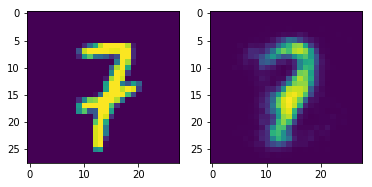

In [215]:
compare_plot(x, z, idx=0)

In [216]:
%time train(autoencoder, trainloader=train_loader, valloader=test_loader, num_epochs=2)

Epoch 1/2
----------
train loss 0.131929
valid loss 0.117059
Epoch 2/2
----------
train loss 0.111982
valid loss 0.105339
CPU times: user 1min 26s, sys: 3.22 s, total: 1min 30s
Wall time: 35.4 s


In [218]:
%time train(autoencoder, trainloader=train_loader, valloader=test_loader, num_epochs=2)

Epoch 1/2
----------
train loss 0.104650
valid loss 0.100961

Epoch 2/2
----------
train loss 0.101456
valid loss 0.098749

CPU times: user 1min 23s, sys: 2.31 s, total: 1min 25s
Wall time: 31.3 s


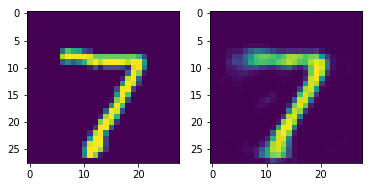

In [220]:
x,y = next(iter(test_loader))
z   = autoencoder(x)
compare_plot(x,z)

---

In [131]:
type(x[0][0])

torch.Tensor

In [130]:
type(z[0][0])

numpy.ndarray

---

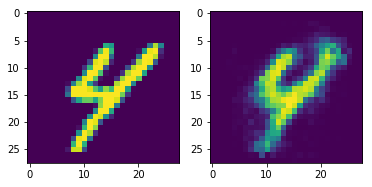

In [212]:
compare_plot(x,z,idx=1)

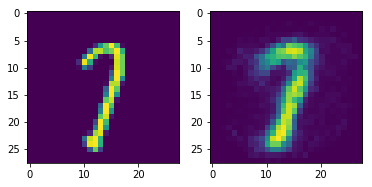

In [213]:
compare_plot(x,z,idx=2)

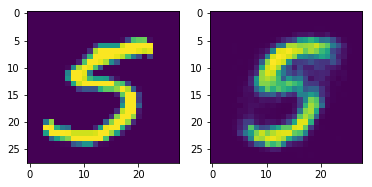

In [214]:
compare_plot(x,z,idx=3)

In [22]:
tmp = copy.deepcopy(train_loader)

In [23]:
tmp.dataset.train_labels = tmp.dataset.train_data

In [84]:
x,y = next(iter(tmp))

In [82]:
(y[0].type(torch.FloatTensor)/255)[8,:20], x[0][0,8,:20]

(tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.2471,  0.9412,  0.9882,  0.9882,  0.9882,  0.5490]),
 tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.2471,  0.9412,  0.9882,  0.9882,  0.9882,  0.5490]))

In [85]:
tmp.dataset.train_labels = tmp.dataset.train_data.type(torch.FloatTensor)/255

In [86]:
x,y = next(iter(tmp))

In [89]:
torch.equal(x[0][0], y[0])

True

In [91]:
tmp.dataset.train_labels.shape, tmp.dataset.train_data.shape

(torch.Size([60000, 28, 28]), torch.Size([60000, 28, 28]))

---

In [102]:
tmp.dataset.train_labels = tmp.dataset.train_labels.reshape((60000,1,28,28))

In [122]:
z = learn.predict()

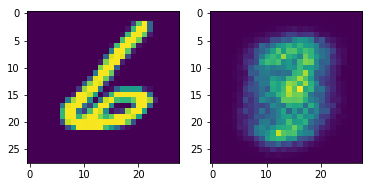

In [133]:
compare_plot()

---

In [181]:
x[0].shape

torch.Size([28, 28])

In [136]:
test_loader.dataset.test_labels.shape

torch.Size([10000])

In [137]:
len(train_loadermd.dataset)

10000

In [93]:
from fastai.conv_learner import *

In [108]:
md = ModelData('data/MNIST', tmp, tmp)

In [109]:
learn = Learner.from_model_data(autoencoder, md)
learn.crit = F.binary_cross_entropy

epoch      trn_loss   val_loss                                  
    0      0.145403   0.166833  


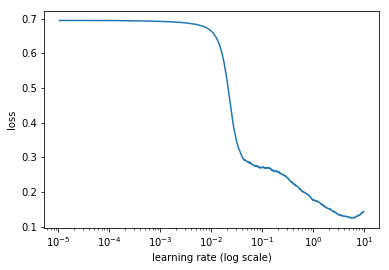

In [110]:
learn.lr_find()
learn.sched.plot()

In [121]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss                                 
    0      0.260972   0.262096  


[0.2620958075960477]